# S2cloudless masking algorithm + grid download
https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless
- This script uses the S2cloudless masking algorithm from the link above, and then creates a grid around my ROI so that I can download 55km cells into a local folder (55km cells maximizes GEE's download capability). I only export the masked image and calculated NDRE band. All other bands are excluded from download. Images exported at 20m scale.

In [4]:
import ee, geemap
print(ee.__version__)
print(geemap.__version__)

0.1.221
0.6.13


In [5]:
ee.Initialize()

In [6]:
br = (ee.FeatureCollection("FAO/GAUL/2015/level1")
      .filterMetadata('ADM0_NAME', 'equals', 'Brazil')
      .aggregate_array('ADM1_NAME')
     )

print(br.getInfo())

['Alagoas', 'Bahia', 'Ceara', 'Espirito Santo', 'Maranhao', 'Minas Gerais', 'Paraiba', 'Pernambuco', 'Piaui', 'Rio De Janeiro', 'Rio Grande Do Norte', 'Sao Paulo', 'Sergipe', 'Name Unknown', 'Name Unknown', 'Name Unknown', 'Acre', 'Amapa', 'Amazonas', 'Distrito Federal', 'Goias', 'Mato Grosso', 'Mato Grosso Do Sul', 'Para', 'Parana', 'Rio Grande Do Sul', 'Rondonia', 'Roraima', 'Santa Catarina', 'Tocantins', 'Name Unknown']


In [7]:
br = (ee.FeatureCollection("FAO/GAUL/2015/level1")
      .filterMetadata('ADM0_NAME', 'equals', 'Brazil')
      .filterMetadata('ADM1_NAME', 'equals', 'Roraima')
     )

### Create advanced cloud mask

In [8]:
AOI = br
START_DATE = '2016-01-01'
END_DATE = '2020-12-31'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [36]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    """Get Sentinel-2 data and join s2cloudless collection
    with Sentinel TOA data."""
    # Import and filter S2 TOA.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
        .sort('CLOUDY_PIXEL_PERCENTAGE', False))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


def add_cloud_bands(img):
    """Create and add cloud bands."""
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))


def add_shadow_bands(img):
    """Create and add cloud shadow bands."""
    # Identify water pixels from the SCL band.
    #not_water = img.select('SCL').neq(6) <- this is for SR, not TOA
    not_water = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
    not_water = not_water.select('NDWI')

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))


def add_cld_shdw_mask(img):
    """Use cloud shadow and shadow bands to create masks."""
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)


def apply_cld_shdw_mask(img):
    """Mask cloudy pixels."""
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

### Add and Apply cloud mask

In [37]:
# Layers to display
s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

In [38]:
# Run functions to create masks and new properties
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

# Object with cloud mask applied
s2_sr = (s2_sr_cld_col
         .map(add_cld_shdw_mask)
         .map(apply_cld_shdw_mask))

### Visualize components of advanced cloud mask

In [39]:
# Create mosaic from collection
img = s2_sr_cld_col_eval_disp.mosaic()

# Subset layers and prepare for visualization
clouds = img.select('clouds').selfMask()
shadows = img.select('shadows').selfMask()
dark_pixels = img.select('dark_pixels').selfMask()
probability = img.select('probability')
cloudmask = img.select('cloudmask').selfMask()
cloud_transform = img.select('cloud_transform')

In [40]:
# Create map for visualization
Map = geemap.Map()

Map.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'S2 Image')
Map.addLayer(clouds, {'palette': 'e056fd'}, 'clouds')
Map.addLayer(shadows, {'palette': 'yellow'}, 'shadows')

Map.center_object(AOI, zoom=7.5)
Map

Map(center=[2.082465819696796, -61.39215640405955], controls=(WidgetControl(options=['position'], widget=HBox(…

### Create NDRE band

In [41]:
# Calculate NDRE
def ndre_band(img):
    """Function to calculate ndre for an image."""
    ndre = img.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return img.addBands(ndre)

# Define NDRE palette
ndre_palette = ['#d73027', '#f46d43', '#fdae61', '#fee08b', 
           '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']

In [42]:
# Apply NDRE function and select only the NDRE band for export
mskd_col = s2_sr.select('B5', 'B8')
calc_ndre_mskd_imgs = mskd_col.map(ndre_band)
ndre_mskd_col = calc_ndre_mskd_imgs.select('NDRE')

# Make sure band was added and selected
bands = ndre_mskd_col.first().bandNames()
print(bands.getInfo())

['NDRE']


### Create polygon grid for clipping images

In [43]:
# Create grid
# https://developers.google.com/earth-engine/tutorials/community/drawing-tools

def make_grid(region, a_scale):
    """
    Creates a grid around a specified ROI.
    User inputs their reasonably small ROI.
    User inputs a scale where 100000 = 100km.
    """
    # Creates image with 2 bands ('longitude', 'latitude') in degrees
    lonLat = ee.Image.pixelLonLat()

    # Select bands, multiply times big number, and truncate
    lonGrid = (lonLat
               .select('latitude')
               .multiply(10000000)
               .toInt()
              )
    latGrid = (lonLat
              .select('longitude')
              .multiply(10000000)
              .toInt()
              )

    # Multiply lat and lon images and reduce to vectors
    grid = (lonGrid
            .multiply(latGrid)
            .reduceToVectors(
                geometry = region,
                scale = a_scale, # 100km-sized boxes needs 100,000
                geometryType = 'polygon')
           )
    
    return(grid)

In [44]:
# Make test grid (half degree squares)
grid_55km = make_grid(br, 55000)

In [45]:
# Access coordinates of grid squares
grid_dict = grid_55km.getInfo()

feats = grid_dict['features']
coord_list = []
for d in feats:
    geom = d['geometry']
    coords = geom['coordinates']
    coord_list.append(coords)

In [46]:
# Create a list of several ee.Geometry.Polygons
polys = []
for coord in coord_list:
    poly = ee.Geometry.Polygon(coord)
    polys.append(poly)

In [47]:
# Make the whole grid a feature collection for export purposes
grid = ee.FeatureCollection(polys)

### Clip NDRE to each polygon from grid

In [48]:
# Clip images in each collection to polygons
clipped_cols = []
for poly in polys:
    ndre_col = ndre_mskd_col
    clipped_col = ndre_col.map(lambda image: image.clip(poly))
    clipped_cols.append(clipped_col)

print(clipped_cols)
print("\nTotal squares: " + str(len(clipped_cols)))

[<ee.imagecollection.ImageCollection object at 0x7f8bf4f4eb38>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f4ebe0>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f4ec18>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f4ed30>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f4eeb8>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f4ef98>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f51080>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f51160>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f51278>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f51358>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f51438>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f51518>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f515f8>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f516d8>, <ee.imagecollection.ImageCollection object at 0x7f8bf4f517b8>, <ee.imagecollection.ImageCollection object at 0x7f8bf4

### Visualize NDRE of one polygon

In [22]:
# Ensure images are clipped properly
Map = geemap.Map()

Map.addLayer(clipped_cols[5].median(), {'palette': ndre_palette, 'min':0, 'max':1}, 'img_1')
Map.addLayer(polys[5], {}, 'outline_1')
Map.addLayer(grid, {}, 'full_grid')
Map.center_object(grid, zoom=7)

Map

Map(center=[2.0715522692429005, -61.388346911704495], controls=(WidgetControl(options=['position'], widget=HBo…

### Apply monthly step to data before export

In [49]:
#Monthly step
#https://gis.stackexchange.com/questions/301165/how-to-get-monthly-averages-from-earth-engine-in-the-python-api
months = ee.List.sequence(1, 12) #Create a list with nums 1-12
years = ee.List.sequence(2017, 2020)

all_cols = []
for a_col in clipped_cols:
    def byYear(y):
        def byMonth(m):
            return (a_col
                    .filter(ee.Filter.calendarRange(y, y, 'year'))
                    .filter(ee.Filter.calendarRange(m, m, 'month'))
                    .median() # Find median NDRE for a month
                    .set('month', m)
                    .set('year', y)
                   )
        return months.map(byMonth)

    col = ee.ImageCollection.fromImages(years.map(byYear).flatten())
    all_cols.append(col) # Should have 18 collections, each collection with yrs*months images

print(all_cols)
imgs = all_cols[0].size()
print(imgs.getInfo())

[<ee.imagecollection.ImageCollection object at 0x7f8bf4961cf8>, <ee.imagecollection.ImageCollection object at 0x7f8bf4998c50>, <ee.imagecollection.ImageCollection object at 0x7f8bf496dc88>, <ee.imagecollection.ImageCollection object at 0x7f8bf495c710>, <ee.imagecollection.ImageCollection object at 0x7f8bf496d860>, <ee.imagecollection.ImageCollection object at 0x7f8bf4975dd8>, <ee.imagecollection.ImageCollection object at 0x7f8bf496d0b8>, <ee.imagecollection.ImageCollection object at 0x7f8bf497f860>, <ee.imagecollection.ImageCollection object at 0x7f8bf4961710>, <ee.imagecollection.ImageCollection object at 0x7f8bf497f9e8>, <ee.imagecollection.ImageCollection object at 0x7f8bf49f3588>, <ee.imagecollection.ImageCollection object at 0x7f8bf497f400>, <ee.imagecollection.ImageCollection object at 0x7f8bf49f3b70>, <ee.imagecollection.ImageCollection object at 0x7f8bf498e668>, <ee.imagecollection.ImageCollection object at 0x7f8bf4197908>, <ee.imagecollection.ImageCollection object at 0x7f8bf4

### Visualize NDRE time series

In [50]:
import matplotlib.pyplot as plt
import numpy as np

In [51]:
# Mean
def region_mean_Image(img):
    # mean over all pixels in the region for the image
    return img.set('mean', img.reduceRegion(ee.Reducer.mean(), geometry=polys[5], scale=30)) 

def region_mean_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_mean_Image)
    stats_list = stats.aggregate_array('mean')
    return np.array(stats_list.getInfo())


# Median
def region_median_Image(img):
    # mean over all pixels in the region for the image
    return img.set('median', img.reduceRegion(ee.Reducer.median(), geometry=polys[5], scale=30)) 

def region_median_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_median_Image)
    stats_list = stats.aggregate_array('median')
    return np.array(stats_list.getInfo())

In [52]:
# Make mean and median lists from collection
mean_list = region_mean_ImageCollection(all_cols[5])
median_list = region_median_ImageCollection(all_cols[5])

In [53]:
print(mean_list)

[{'NDRE': 0.5181484148174041} {'NDRE': 0.5577024852555459}
 {'NDRE': 0.5270850495063659} {'NDRE': None} {'NDRE': 0.5053128924891914}
 {'NDRE': 0.5137563251522471} {'NDRE': 0.514614792600414}
 {'NDRE': 0.528797380935452} {'NDRE': 0.5329522139342768}
 {'NDRE': 0.5520435611209913} {'NDRE': 0.5353351617435151}
 {'NDRE': 0.512528112680367} {'NDRE': 0.47726653986573636}
 {'NDRE': 0.5135633900955175} {'NDRE': 0.48929714249781514}
 {'NDRE': 0.44797110309701593} {'NDRE': 0.5172549890689481}
 {'NDRE': 0.5454089252528215} {'NDRE': 0.527071055573593}
 {'NDRE': 0.5192992007558758} {'NDRE': 0.5253362291659661}
 {'NDRE': 0.5189915645006581} {'NDRE': 0.5074920528158726}
 {'NDRE': 0.4828912182455498} {'NDRE': 0.5349120484988789}
 {'NDRE': 0.5121473879900132} {'NDRE': 0.4807651350689961}
 {'NDRE': 0.4683689617074272} {'NDRE': 0.5121550118440145}
 {'NDRE': 0.5531650999334111} {'NDRE': 0.5095357067891518}
 {'NDRE': 0.533084836574937} {'NDRE': 0.5030638301977114}
 {'NDRE': 0.5248164843653581} {'NDRE': 0.52

In [54]:
# Make list of values
empty = {}
def newList(alist):
    list_name = []
    for value in alist:
        if value != empty:
            list_name.append(value)
        else:
            list_name.append({'NDRE': np.nan})
    return list_name

In [55]:
# Make mean and median value lists
mean_ndre = newList(mean_list)
median_ndre = newList(median_list)

In [56]:
print(mean_ndre)

[{'NDRE': 0.5181484148174041}, {'NDRE': 0.5577024852555459}, {'NDRE': 0.5270850495063659}, {'NDRE': None}, {'NDRE': 0.5053128924891914}, {'NDRE': 0.5137563251522471}, {'NDRE': 0.514614792600414}, {'NDRE': 0.528797380935452}, {'NDRE': 0.5329522139342768}, {'NDRE': 0.5520435611209913}, {'NDRE': 0.5353351617435151}, {'NDRE': 0.512528112680367}, {'NDRE': 0.47726653986573636}, {'NDRE': 0.5135633900955175}, {'NDRE': 0.48929714249781514}, {'NDRE': 0.44797110309701593}, {'NDRE': 0.5172549890689481}, {'NDRE': 0.5454089252528215}, {'NDRE': 0.527071055573593}, {'NDRE': 0.5192992007558758}, {'NDRE': 0.5253362291659661}, {'NDRE': 0.5189915645006581}, {'NDRE': 0.5074920528158726}, {'NDRE': 0.4828912182455498}, {'NDRE': 0.5349120484988789}, {'NDRE': 0.5121473879900132}, {'NDRE': 0.4807651350689961}, {'NDRE': 0.4683689617074272}, {'NDRE': 0.5121550118440145}, {'NDRE': 0.5531650999334111}, {'NDRE': 0.5095357067891518}, {'NDRE': 0.533084836574937}, {'NDRE': 0.5030638301977114}, {'NDRE': 0.52481648436535

In [57]:
def valList(aList):
    new_list = []
    for d in aList:
        for key, val in d.items():
            new_list.append(val)
    return new_list

In [58]:
a_mean = np.array(valList(mean_ndre))
a_median = np.array(valList(median_ndre))
print(a_mean)

[0.5181484148174041 0.5577024852555459 0.5270850495063659 None
 0.5053128924891914 0.5137563251522471 0.514614792600414 0.528797380935452
 0.5329522139342768 0.5520435611209913 0.5353351617435151
 0.512528112680367 0.47726653986573636 0.5135633900955175
 0.48929714249781514 0.44797110309701593 0.5172549890689481
 0.5454089252528215 0.527071055573593 0.5192992007558758
 0.5253362291659661 0.5189915645006581 0.5074920528158726
 0.4828912182455498 0.5349120484988789 0.5121473879900132
 0.4807651350689961 0.4683689617074272 0.5121550118440145
 0.5531650999334111 0.5095357067891518 0.533084836574937
 0.5030638301977114 0.5248164843653581 0.5201370147244717
 0.5173533306938812 0.5417601775728285 0.4758818915407378
 0.508085040117499 0.4989888464482405 0.54046914028591 0.5113123300212353
 0.5454384602122413 0.5085036703985075 0.5326416625639286
 0.5339360935932538 0.5344392467014948 0.49467110962663746]


In [59]:
# Create month list
months = np.array(range(len(a_mean)))
print(months)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


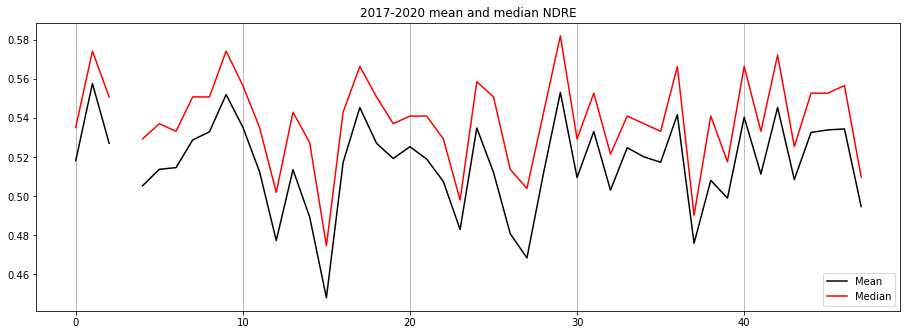

In [60]:
# Make plot
x = months
y = a_mean
m = a_median

#ticks1 = list(range(0,48))
plt.axes([0, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2017-2020 mean and median NDRE')
#plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")

mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")

plt.legend(loc = "lower right")
#plt.xticks(ticks = ticks1)
#plt.xticks(ticks = [0, 6, 12, 18, 24, 30, 36, 42, 47], labels = ['2016', 'Jul', '2017', 'Jul', '2018', 'Jul', '2019', 'Jul', 'Dec'])
plt.show()

### Export monthly images (60) from each collection (18): 1,080 images total

In [61]:
size = all_cols[0].size()
print(size.getInfo())

48


In [62]:
# Make a list of file names for espirito santo
tiles = []
sitename = 'espirito_santo'
for num in range(len(all_cols)):
    index = str('espirito_santo' + '_{}'.format(num))
    tiles.append(index)

print(tiles)

['espirito_santo_0', 'espirito_santo_1', 'espirito_santo_2', 'espirito_santo_3', 'espirito_santo_4', 'espirito_santo_5', 'espirito_santo_6', 'espirito_santo_7', 'espirito_santo_8', 'espirito_santo_9', 'espirito_santo_10', 'espirito_santo_11', 'espirito_santo_12', 'espirito_santo_13', 'espirito_santo_14', 'espirito_santo_15', 'espirito_santo_16', 'espirito_santo_17', 'espirito_santo_18', 'espirito_santo_19', 'espirito_santo_20', 'espirito_santo_21', 'espirito_santo_22', 'espirito_santo_23', 'espirito_santo_24', 'espirito_santo_25', 'espirito_santo_26', 'espirito_santo_27', 'espirito_santo_28', 'espirito_santo_29', 'espirito_santo_30', 'espirito_santo_31', 'espirito_santo_32', 'espirito_santo_33', 'espirito_santo_34', 'espirito_santo_35', 'espirito_santo_36', 'espirito_santo_37', 'espirito_santo_38', 'espirito_santo_39', 'espirito_santo_40', 'espirito_santo_41', 'espirito_santo_42', 'espirito_santo_43', 'espirito_santo_44', 'espirito_santo_45', 'espirito_santo_46', 'espirito_santo_47', '

In [63]:
import os

In [64]:
# Export monthly images from a collection
for a_col, a_tile, poly in zip(all_cols, tiles, polys):
    ilist = a_col.toList(a_col.size())
    for i in range(12*3):
        if len(ee.Image(ilist.get(i)).bandNames().getInfo()) <= 0:
            print("ERROR; No bands found in image index %d... will skip export."%(i))
        else:
            print("Exporting Image %d"%(i))
            #print(ee.Image(ilist.get(i)).bandNames().getInfo())
            filename = "/Users/morgansteckler/Desktop/tropical_phenology_gee/morgan/test/{}/{}.tif".format(a_tile,i)
            temp_dir = "/Users/morgansteckler/Desktop/tropical_phenology_gee/morgan/test/{}".format(a_tile)
            if not os.path.exists(temp_dir):
                os.mkdir(temp_dir)
            geemap.ee_export_image(ee.Image(ilist.get(i)).select('NDRE'), 
                                   filename=filename, 
                                   scale=30, 
                                   region=poly, 
                                   file_per_band=False)

Exporting Image 0
Generating URL ...
Please wait ...
Data downloaded to /Users/morgansteckler/Desktop/tropical_phenology_gee/morgan/test/espirito_santo_0/0.tif
Exporting Image 1
Generating URL ...
Please wait ...
Data downloaded to /Users/morgansteckler/Desktop/tropical_phenology_gee/morgan/test/espirito_santo_0/1.tif
Exporting Image 2
Generating URL ...


KeyboardInterrupt: 